# Tree comparison

## Preparation

In [22]:
import pandas as pd
from pathlib import Path
#import matplotlib.pyplot as plt
#import numpy as np
#from ete3 import Tree
from ete3 import PhyloTree
import os
import matplotlib.pyplot as plt

In [23]:
project_path = Path().resolve().parent
species_tree_path=project_path / "results" / "intermediate" / "species_trees_mod" / "Lactobacillus gasseri.nw"
gene_tree_path=project_path / "results" / "intermediate" / "sel_gene_trees_mod" / "Lactobacillus gasseri"
pangenome_path = project_path / "results" / "intermediate" / "sel_pan" / "pangenome.tsv"



In [161]:
font = {'family' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

## Load gene and species trees

In [24]:
with open(species_tree_path, 'r') as f:
    species_tree=f.read()

species_tree=PhyloTree(species_tree)
species_tree.set_species_naming_function(lambda node: node.name)


In [25]:
print(species_tree)


      /-GCA_000283135.1
   /-|
  |  |   /-GCA_000155935.2
  |   \-|
  |      \-GCA_000177415.1
  |
  |   /-GCA_000615125.1
  |  |
  |  |         /-GCA_002863445.1
  |  |      /-|
  |--|     |  |   /-GCA_002863425.1
--|  |   /-|   \-|
  |  |  |  |      \-GCA_000175055.1
  |  |  |  |
  |   \-|   \-GCA_001546525.1
  |     |
  |     |      /-GCA_002287905.1
  |     |   /-|
  |      \-|   \-GCA_003307315.1
  |        |
  |         \-GCA_001064985.1
  |
   \-GCA_003437055.1


In [68]:
pangenome = pd.read_csv(pangenome_path, sep="\t", header=None)
pangenome.columns=['gene', 'genome', 'orthogroup']
#pangenome.sort_values(by='orthogroup', inplace=True)
pangenome.sort_values(by='gene', inplace=True)
pangenome

,gene,genome,orthogroup
19000,ACOZ01000001.1_1,GCA_000175055.1,F12524_1
7543,ACOZ01000001.1_2,GCA_000175055.1,F00941_1
11182,ACOZ01000001.1_3,GCA_000175055.1,F02992_1
6389,ACOZ01000001.1_4,GCA_000175055.1,F02014_10
2271,ACOZ01000001.1_5,GCA_000175055.1,F00087_1
...,...,...,...
19472,QSRM01000027.1_1,GCA_003437055.1,F02826_2
967,QSRM01000027.1_2,GCA_003437055.1,F01366_2
5702,QSRM01000027.1_3,GCA_003437055.1,F00998_2
908,QSRM01000027.1_4,GCA_003437055.1,F02051_1


In [28]:
def remove_duplications_in_endnodes(gene_tree):
    seen = set()
    duplicates = [name for name in gene_tree.get_leaf_names() if name in seen or seen.add(name)]
    for name in duplicates:
        node_collection=gene_tree.search_nodes(name=name)
        num=len(node_collection)
        check_until=num-1
        for i in range(0, num):
            for j in range(i+1, num):
                sis=node_collection[i].get_sisters()
                if(sis):
                    if node_collection[i].get_sisters()[0]==node_collection[j]:
                        node_collection[i].delete()

In [29]:
def read_gene_tree(filename):

    with open(gene_tree_path / filename, 'r') as f:
        gene_tree=f.read()

    gene_tree=PhyloTree(gene_tree)
    gene_tree.set_species_naming_function(lambda node1: pangenome.iloc[:,1][pangenome.iloc[:,0] == node1.name].item())
    
    newnames = [node.species for node in gene_tree.get_leaves()]
    nodes = gene_tree.get_leaves()
    for i in range(0,len(nodes)):
        nodes[i].name=newnames[i]
    remove_duplications_in_endnodes(gene_tree)
    return gene_tree

In [30]:
gene_tree=read_gene_tree("F00001_1.nw")

## Compare gene and species tree

In [31]:
comp=gene_tree.compare(species_tree, has_duplications=True, unrooted=True)

In [32]:
comp

{'treeko_dist': 0.5,
 'rf': 1.3333333333333333,
 'max_rf': 4,
 'effective_tree_size': 3.3333333333333335,
 'norm_rf': 0.3333333333333333,
 'ref_edges_in_source': 0.8333333333333333,
 'source_edges_in_ref': 0.8333333333333333,
 'source_subtrees': 3,
 'common_edges': set(),
 'source_edges': set(),
 'ref_edges': set()}

## Distribution of treeko scores

In [43]:
scores = pd.DataFrame(np.zeros((len(os.listdir(gene_tree_path)), 2)))
#pangenome['treeko']=-1
index=0
for filename in os.listdir(gene_tree_path):
    if not filename.startswith('.'):
        print(filename)
        orthogroup=filename.split('.')[0]
        print(orthogroup)
        gene_tree=read_gene_tree(filename)
        comp=gene_tree.compare(species_tree, has_duplications=True, unrooted=True)
        dist=comp.get('treeko_dist')
        print(dist)
        #pangenome.loc[pangenome.iloc[:,0]==gene, 'treeko']=dist
        #df['flag'][df.name.str.contains('e$')] = 'Blue'
        scores.iat[index,0]=orthogroup
        scores.iat[index,1]=dist
        index = index+1;
        

F00705_2.nw
F00705_2
0.75
F29934_1.nw
F29934_1
0.75
F06324_1.nw
F06324_1
0.7556818181818182
F00897_14.nw
F00897_14
0.5
F02388_1.nw
F02388_1
0.0
F06148_1.nw
F06148_1
0.6675170068027211
F03715_2.nw
F03715_2
0.625
F03446_3.nw
F03446_3
0.9248120300751879
F05291_2.nw
F05291_2
1.0
F06373_1.nw
F06373_1
0.75
F00952_3.nw
F00952_3
0.875
F02625_1.nw
F02625_1
1.0
F00836_6.nw
F00836_6
0.875
F01009_1.nw
F01009_1
0.375
F07974_1.nw
F07974_1
0.8
F01770_1.nw
F01770_1
0.5714285714285714
F00862_1.nw
F00862_1
0.0
F09205_1.nw
F09205_1
0.25
F04067_1.nw
F04067_1
0.625
F02446_2.nw
F02446_2
0.875
F01990_3.nw
F01990_3
0.75
F06959_1.nw
F06959_1
0.75
F00069_5.nw
F00069_5
0.625
F07124_1.nw
F07124_1
0.4225925925925926
F37592_1.nw
F37592_1
0.5
F02776_1.nw
F02776_1
0.75
F52538_1.nw
F52538_1
0.7142857142857143
F03022_1.nw
F03022_1
1.0
F26696_1.nw
F26696_1
1.0
F02846_2.nw
F02846_2
1.0
F03429_5.nw
F03429_5
0.75
F02216_3.nw
F02216_3
0.75
F02515_2.nw
F02515_2
0.75
F00198_1.nw
F00198_1
0.35
F00013_4.nw
F00013_4
0.5
F03099_6

0.875
F06517_3.nw
F06517_3
0.7205882352941176
F01181_2.nw
F01181_2
1.0
F00239_67.nw
F00239_67
0.7692307692307693
F00139_3.nw
F00139_3
0.625
F00867_38.nw
F00867_38
0.75
F03222_1.nw
F03222_1
0.875
F00051_2.nw
F00051_2
0.7954545454545454
F02126_1.nw
F02126_1
1.0
F07324_1.nw
F07324_1
0.5
F00114_2.nw
F00114_2
0.75
F02129_2.nw
F02129_2
0.75
F02825_1.nw
F02825_1
0.7115384615384616
F01477_6.nw
F01477_6
0.8
F03738_2.nw
F03738_2
0.875
F00787_10.nw
F00787_10
1.0
F01569_2.nw
F01569_2
0.5
F00439_4.nw
F00439_4
0.875
F02580_2.nw
F02580_2
0.75
F01713_2.nw
F01713_2
0.75
F01838_06.nw
F01838_06
0.25
F00560_15.nw
F00560_15
0.5925925925925926
F03408_1.nw
F03408_1
1.0
F01722_9.nw
F01722_9
0.875
F04267_1.nw
F04267_1
0.2916666666666667
F02238_4.nw
F02238_4
0.75
F01966_1.nw
F01966_1
0.75
F02000_11.nw
F02000_11
0.75
F01102_3.nw
F01102_3
0.75
F03799_1.nw
F03799_1
0.5909090909090909
F12864_1.nw
F12864_1
0.875
F06982_2.nw
F06982_2
0.8263888888888888
F01314_2.nw
F01314_2
0.75
F00623_1.nw
F00623_1
0.0
F02611_2.nw
F0

0.4777777777777778
F01961_1.nw
F01961_1
0.3783783783783784
F00852_5.nw
F00852_5
0.4125
F01062_1.nw
F01062_1
0.0
F07159_1.nw
F07159_1


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.75
F07509_1.nw
F07509_1
0.5
F01824_1.nw
F01824_1
0.25
F03399_1.nw
F03399_1
0.75
F01506_11.nw
F01506_11
0.75
F06898_1.nw
F06898_1
0.75
F05758_1.nw
F05758_1
0.75
F00606_3.nw
F00606_3
1.0
F03376_1.nw
F03376_1
0.625
F02879_5.nw
F02879_5
1.0
F01581_2.nw
F01581_2
0.65
F01629_13.nw
F01629_13
0.6675170068027211
F00517_5.nw
F00517_5
0.75
F02658_1.nw
F02658_1
0.875
F02933_09.nw
F02933_09
0.5288461538461539
F00370_1.nw
F00370_1
0.3333333333333333
F00067_9.nw
F00067_9
0.6666666666666666
F02319_6.nw
F02319_6
0.625
F01165_6.nw
F01165_6
0.75
F02968_2.nw
F02968_2
0.875
F02803_4.nw
F02803_4
0.75
F28030_1.nw
F28030_1
1.0
F00691_13.nw
F00691_13
0.85625
F02787_3.nw
F02787_3
0.75
F02451_11.nw
F02451_11
0.75
F02621_7.nw
F02621_7
0.875
F11920_1.nw
F11920_1
1.0
F00956_5.nw
F00956_5
0.625
F00282_2.nw
F00282_2
0.875
F02930_1.nw
F02930_1
0.75
F00020_7.nw
F00020_7
0.75
F02012_4.nw
F02012_4
0.75
F06836_1.nw
F06836_1
0.75
F01078_5.nw
F01078_5
0.7115384615384616
F01077_6.nw
F01077_6
0.75
F02875_1.nw
F02875_1
0.5
F

0.75
F02161_2.nw
F02161_2
0.875
F00172_4.nw
F00172_4
0.5
F02494_1.nw
F02494_1
0.0
F07679_1.nw
F07679_1
1.0
F00016_1.nw
F00016_1
0.875
F01808_3.nw
F01808_3
1.0
F06438_1.nw
F06438_1
0.8
F00915_1.nw
F00915_1
0.5
F03321_3.nw
F03321_3
0.75
F07461_2.nw
F07461_2
0.41371428571428576
F09923_1.nw
F09923_1
1.0
F01809_2.nw
F01809_2
0.8412698412698412
F00053_9.nw
F00053_9
0.4108108108108108
F11806_1.nw
F11806_1
1.0
F03138_1.nw
F03138_1
1.0
F02400_1.nw
F02400_1
0.875
F02050_1.nw
F02050_1
1.0
F03163_5.nw
F03163_5
0.75
F01520_3.nw
F01520_3
0.5607142857142857
F06112_8.nw
F06112_8
0.75
F01366_2.nw
F01366_2
0.4301075268817204
F04215_1.nw
F04215_1
0.75
F03160_2.nw
F03160_2
0.5
F06414_1.nw
F06414_1
0.5
F39357_1.nw
F39357_1
0.0
F03246_1.nw
F03246_1
0.0
F00936_2.nw
F00936_2
0.75
F00893_1.nw
F00893_1
0.375
F00465_2.nw
F00465_2
0.5433333333333333
F06947_1.nw
F06947_1
0.6
F00985_05.nw
F00985_05
1.0
F06802_1.nw
F06802_1
0.6573359073359073
F00838_8.nw
F00838_8
0.75
F01680_8.nw
F01680_8
0.75
F03303_1.nw
F03303_1
1

0.0
F02748_4.nw
F02748_4
0.75
F00975_5.nw
F00975_5
0.75
F07838_1.nw
F07838_1
0.5
F01515_1.nw
F01515_1
0.8571428571428571
F52527_1.nw
F52527_1
0.6666666666666666
F00937_2.nw
F00937_2
0.875
F02182_7.nw
F02182_7
0.625
F02459_2.nw
F02459_2
0.75
F07204_1.nw
F07204_1
0.5
F00985_14.nw
F00985_14
1.0
F12143_1.nw
F12143_1
0.0
F06550_1.nw
F06550_1
0.8260869565217391
F06100_1.nw
F06100_1
0.7142857142857143
F09975_1.nw
F09975_1
0.5972222222222222
F00257_1.nw
F00257_1
0.8552631578947368
F03474_2.nw
F03474_2
1.0
F03181_1.nw
F03181_1
0.75
F01153_1.nw
F01153_1
0.375
F02286_6.nw
F02286_6
0.75
F02051_1.nw
F02051_1
0.4583333333333333
F12051_1.nw
F12051_1
0.6666666666666666
F01222_2.nw
F01222_2
0.875
F25638_2.nw
F25638_2
0.7329931972789115
F00558_4.nw
F00558_4
0.875
F00071_18.nw
F00071_18
0.3703703703703704
F01942_1.nw
F01942_1
0.35714285714285715
F02397_1.nw
F02397_1
0.75
F02595_9.nw
F02595_9
0.75
F12682_1.nw
F12682_1
1.0
F06291_1.nw
F06291_1
0.75
F01258_3.nw
F01258_3
0.14285714285714285
F03403_6.nw
F0340

0.5555555555555556
F12410_1.nw
F12410_1
0.875
F28444_1.nw
F28444_1
0.75
F00486_8.nw
F00486_8
0.75
F07307_1.nw
F07307_1
0.7142857142857143
F00568_1.nw
F00568_1
0.75
F04878_1.nw
F04878_1
0.6537037037037037
F06845_1.nw
F06845_1
0.6346153846153846
F05784_1.nw
F05784_1
0.0
F00589_2.nw
F00589_2
0.625
F04175_2.nw
F04175_2
0.75
F12104_1.nw
F12104_1
0.6666666666666666
F01682_1.nw
F01682_1
0.75
F00814_7.nw
F00814_7
0.75
F01401_1.nw
F01401_1
0.5
F08270_1.nw
F08270_1
0.75
F02464_3.nw
F02464_3
0.75
F07490_1.nw
F07490_1
0.75
F03276_4.nw
F03276_4
0.5
F05383_1.nw
F05383_1
0.75
F00181_1.nw
F00181_1
0.875
F06813_1.nw
F06813_1
0.8664965986394557
F00398_3.nw
F00398_3
0.75
F02377_10.nw
F02377_10
0.625
F04984_1.nw
F04984_1
1.0
F01589_3.nw
F01589_3
0.9435483870967742
F12153_1.nw
F12153_1
1.0
F03464_2.nw
F03464_2
0.8181818181818182
F00818_3.nw
F00818_3
0.75
F52521_1.nw
F52521_1
0.6
F11143_1.nw
F11143_1
0.5
F07202_1.nw
F07202_1
0.612781954887218
F01989_3.nw
F01989_3
0.875
F00361_3.nw
F00361_3
0.499047619047619

In [145]:
scores.columns=['orthogroup', 'treeko']
scores

,orthogroup,treeko
0,F00705_2,0.750000
1,F29934_1,0.750000
2,F06324_1,0.755682
3,F00897_14,0.500000
4,F02388_1,0.000000
...,...,...
1581,F05713_2,0.750000
1582,F00577_24,0.000000
1583,F02870_1,0.571429
1584,F02039_2,0.750000


In [146]:
pan_score=pangenome.merge(scores,on='orthogroup')
pan_score.sort_values(by='gene', inplace=True)
pan_score=pan_score.reset_index(drop=True)
pan_score

,gene,genome,orthogroup,treeko
0,ACOZ01000001.1_1,GCA_000175055.1,F12524_1,0.875000
1,ACOZ01000001.1_2,GCA_000175055.1,F00941_1,0.625000
2,ACOZ01000001.1_3,GCA_000175055.1,F02992_1,0.625000
3,ACOZ01000001.1_4,GCA_000175055.1,F02014_10,0.666667
4,ACOZ01000001.1_5,GCA_000175055.1,F00087_1,0.726190
...,...,...,...,...
21704,QSRM01000027.1_1,GCA_003437055.1,F02826_2,0.357143
21705,QSRM01000027.1_2,GCA_003437055.1,F01366_2,0.430108
21706,QSRM01000027.1_3,GCA_003437055.1,F00998_2,0.634921
21707,QSRM01000027.1_4,GCA_003437055.1,F02051_1,0.458333


Text(0, 0.5, 'Number of genes')

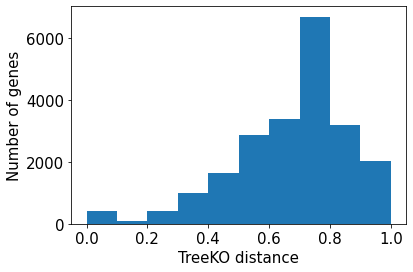

In [162]:
plt.hist(pan_score.treeko)
plt.xlabel('TreeKO distance')
plt.ylabel('Number of genes')

Text(0.5, 1.0, 'Distribution of treeKO distances for all \n orthogroups in $\\it{Lactobacillus}$ $\\it{gasseri}$')

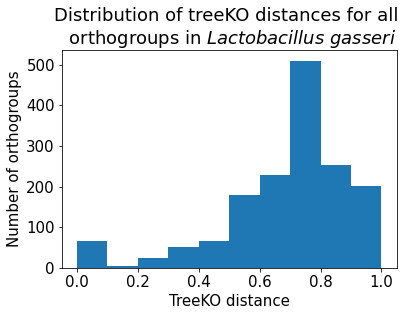

In [178]:
fig, ax = plt.subplots()
ax.hist(scores.loc[:,'treeko'])
#plt.set
plt.xlabel('TreeKO distance', fontsize=15)
plt.ylabel('Number of orthogroups', fontsize=15)
plt.title('Distribution of treeKO distances for all \n orthogroups in $\it{Lactobacillus}$ $\it{gasseri}$')

In [182]:
font = {'family' : 'normal',
        'size'   : 20}

plt.rc('font', **font)

(array([11.,  3.,  2.,  7., 14., 38., 45., 91., 43., 38.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


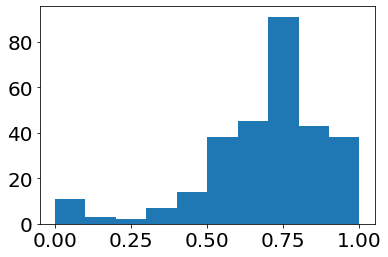

In [183]:
plt.hist(treeko_scores)

In [150]:
len(os.listdir(gene_tree_path))

1586

In [151]:
orthogroup='a'
score = -1
pangenome['treeko_dist']=-1
for index in range(0, len(pangenome)):
    if pangenome.iloc[index, 2]==orthogroup:
        pangenome.iloc[index,3]=score

In [176]:
len(pangenome.genome.drop_duplicates())

12

## Mobility plot

In [152]:
genome='GCA_003437055.1'
order=pan_score.loc[pan_score.genome=='GCA_003437055.1']
order=order.reset_index(drop=True)

In [153]:
order

,gene,genome,orthogroup,treeko
0,QSRM01000001.1_1,GCA_003437055.1,F03442_1,0.750000
1,QSRM01000001.1_10,GCA_003437055.1,F07849_1,0.750000
2,QSRM01000001.1_100,GCA_003437055.1,F03519_1,0.750000
3,QSRM01000001.1_101,GCA_003437055.1,F03446_3,0.924812
4,QSRM01000001.1_102,GCA_003437055.1,F05377_1,0.698387
...,...,...,...,...
1776,QSRM01000027.1_1,GCA_003437055.1,F02826_2,0.357143
1777,QSRM01000027.1_2,GCA_003437055.1,F01366_2,0.430108
1778,QSRM01000027.1_3,GCA_003437055.1,F00998_2,0.634921
1779,QSRM01000027.1_4,GCA_003437055.1,F02051_1,0.458333


In [154]:
split_gene=order.gene.str.split("_", n=1, expand=True)

order['contig']=split_gene[0]
order['order']=pd.to_numeric(split_gene[1])

order.sort_values(by=['contig', 'order'], inplace=True)
order=order.reset_index(drop=True)
order

,gene,genome,orthogroup,treeko,contig,order
0,QSRM01000001.1_1,GCA_003437055.1,F03442_1,0.750000,QSRM01000001.1,1
1,QSRM01000001.1_2,GCA_003437055.1,F00087_1,0.726190,QSRM01000001.1,2
2,QSRM01000001.1_3,GCA_003437055.1,F02014_10,0.666667,QSRM01000001.1,3
3,QSRM01000001.1_4,GCA_003437055.1,F02992_1,0.625000,QSRM01000001.1,4
4,QSRM01000001.1_5,GCA_003437055.1,F00941_1,0.625000,QSRM01000001.1,5
...,...,...,...,...,...,...
1776,QSRM01000027.1_1,GCA_003437055.1,F02826_2,0.357143,QSRM01000027.1,1
1777,QSRM01000027.1_2,GCA_003437055.1,F01366_2,0.430108,QSRM01000027.1,2
1778,QSRM01000027.1_3,GCA_003437055.1,F00998_2,0.634921,QSRM01000027.1,3
1779,QSRM01000027.1_4,GCA_003437055.1,F02051_1,0.458333,QSRM01000027.1,4


In [155]:
counts=order[['contig', 'order']].groupby('contig').count()
counts=counts.reset_index()
counts.columns=['contig', 'count']
order=order.merge(counts, on='contig')
order=order.loc[order['count']>20]
order

,gene,genome,orthogroup,treeko,contig,order,count
0,QSRM01000001.1_1,GCA_003437055.1,F03442_1,0.750000,QSRM01000001.1,1,455
1,QSRM01000001.1_2,GCA_003437055.1,F00087_1,0.726190,QSRM01000001.1,2,455
2,QSRM01000001.1_3,GCA_003437055.1,F02014_10,0.666667,QSRM01000001.1,3,455
3,QSRM01000001.1_4,GCA_003437055.1,F02992_1,0.625000,QSRM01000001.1,4,455
4,QSRM01000001.1_5,GCA_003437055.1,F00941_1,0.625000,QSRM01000001.1,5,455
...,...,...,...,...,...,...,...
1710,QSRM01000017.1_20,GCA_003437055.1,F06086_1,0.750000,QSRM01000017.1,20,24
1711,QSRM01000017.1_21,GCA_003437055.1,F02512_3,1.000000,QSRM01000017.1,21,24
1712,QSRM01000017.1_22,GCA_003437055.1,F05706_1,0.500000,QSRM01000017.1,22,24
1713,QSRM01000017.1_23,GCA_003437055.1,F04404_7,0.500000,QSRM01000017.1,23,24


In [156]:
order[450:500]

,gene,genome,orthogroup,treeko,contig,order,count
450,QSRM01000001.1_460,GCA_003437055.1,F12494_1,0.500000,QSRM01000001.1,460,455
451,QSRM01000001.1_462,GCA_003437055.1,F01961_1,0.378378,QSRM01000001.1,462,455
452,QSRM01000001.1_463,GCA_003437055.1,F01819_1,0.583333,QSRM01000001.1,463,455
453,QSRM01000001.1_464,GCA_003437055.1,F01824_1,0.250000,QSRM01000001.1,464,455
454,QSRM01000001.1_465,GCA_003437055.1,F00453_2,0.788235,QSRM01000001.1,465,455
455,QSRM01000002.1_1,GCA_003437055.1,F06460_1,0.350877,QSRM01000002.1,1,276
456,QSRM01000002.1_2,GCA_003437055.1,F02577_2,0.882239,QSRM01000002.1,2,276
457,QSRM01000002.1_3,GCA_003437055.1,F06291_1,0.750000,QSRM01000002.1,3,276
458,QSRM01000002.1_4,GCA_003437055.1,F06881_1,0.601562,QSRM01000002.1,4,276
459,QSRM01000002.1_5,GCA_003437055.1,F00171_7,0.659259,QSRM01000002.1,5,276


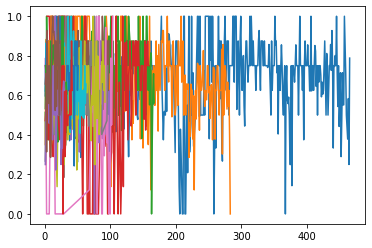

In [130]:
for contig in order.contig.drop_duplicates():
    order_contig=order.loc[order.contig==contig]
    plt.plot(order_contig.order, order_contig.treeko)

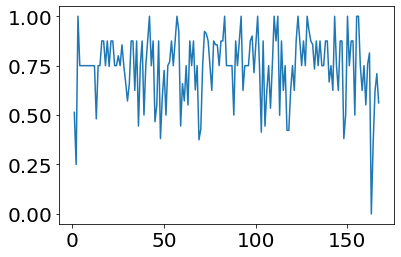

In [187]:
#contig='QSRM01000001.1'
#contig='QSRM01000002.1'
contig=order.contig.drop_duplicates().iloc[2]
order_contig=order.loc[order.contig==contig]
plt.plot(order_contig.order, order_contig.treeko)

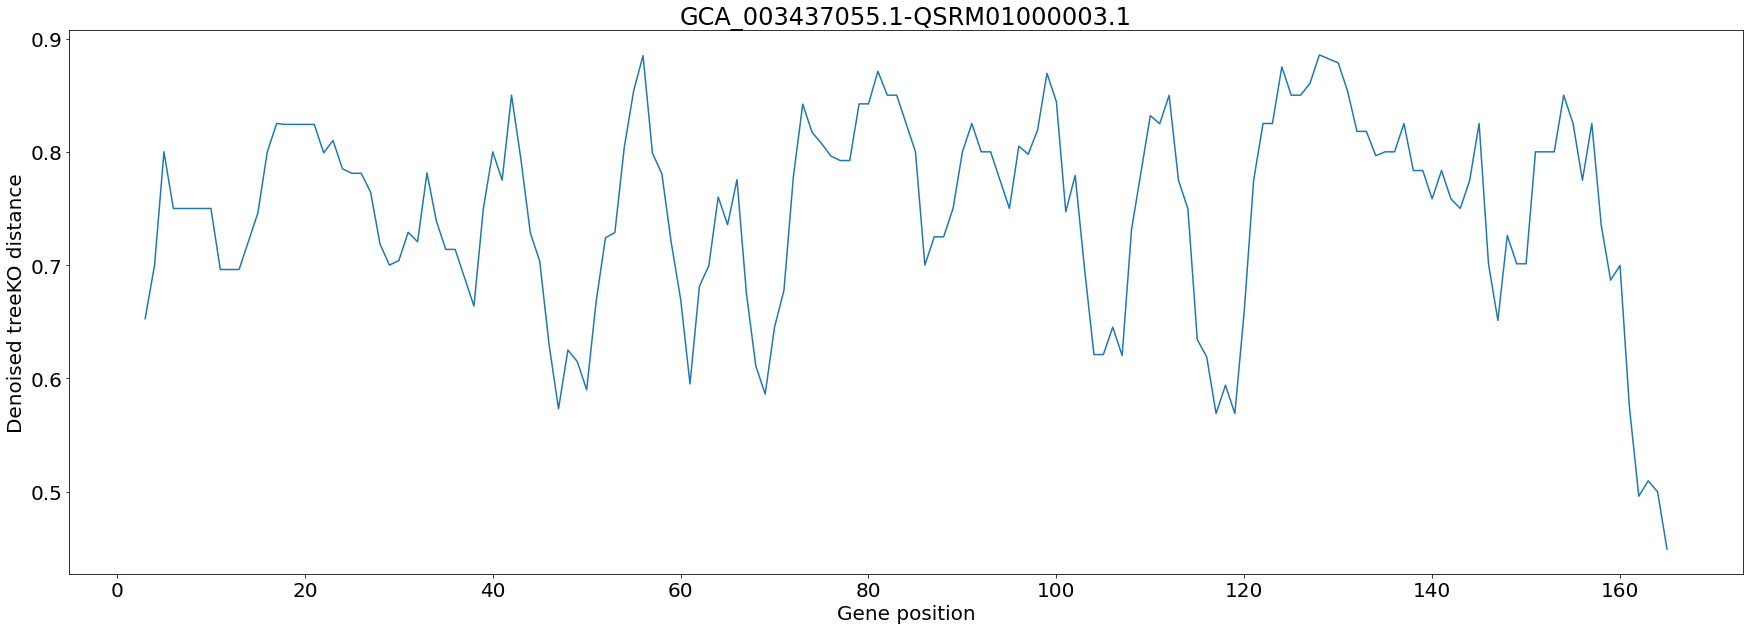

In [188]:
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(order_contig.order, order_contig.treeko.rolling(window=5,center=True).mean())
    #ax.scatter(mob_order_acc.order, mob_order_acc[method].rolling(window=n, center=True).mean(), c=mob_order_acc.accessory, marker='o', label=mob_order_acc.accessory)
    # ['accessory or multi copy', 'single copy core']
    #y=mob_order_acc[method].rolling(window=n,center=True).mean()
    # Prophage Hunter
    #y1=y.iloc[x]
    #ax.scatter(x, y1, c='red', marker='o', label = "Prophage Hunter prediction")
    # Phaster
    #y2=y.iloc[x2]
    #ax.scatter(x2, y2, c='red', marker='o', label = "Phaster prediction")
    #ax.legend(fontsize=20)
ax.set_xlabel("Gene position")
ax.set_ylabel("Denoised treeKO distance")
ax.set_title(str(genome + "-" +contig))
    #ax.tick_params(labelsize=18)
    #legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Core'),
    #               Line2D([0], [0], marker='o', color='red', label='Accessory')]
    #ax.legend(handles=legend_elements, fontsize=20)
#ax.legend(loc=1)
plt.show()

Text(0.5, 1.0, 'Distribution of treeKO distances for all \n orthogroups in genome GCA_003437055.1')

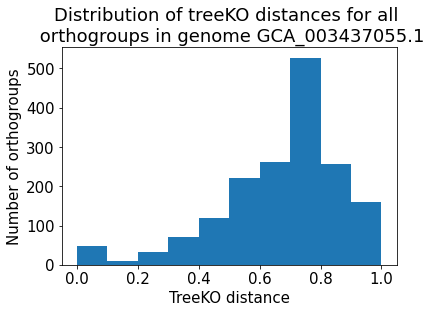

In [177]:
fig, ax = plt.subplots()
ax.hist(order.loc[:,'treeko'])
#plt.set
plt.xlabel('TreeKO distance', fontsize=15)
plt.ylabel('Number of orthogroups', fontsize=15)
plt.title('Distribution of treeKO distances for all \n orthogroups in genome GCA_003437055.1')